# 네이버 영화리뷰 감성분석

## 1. 데이터 준비와 확인

In [56]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [68]:
train_data.shape

(146183, 3)

## 2. 데이터로더 구성

In [59]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [69]:
# 숫자로 인코딩 되었다.
X_train.shape

(146182, 41)

In [61]:
# 인덱스를 문자로
index_to_word = {index:word for word, index in word_to_index.items()}

In [71]:
len(word_to_index)

10001

In [63]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [64]:
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['나'])  # 4 이 출력됩니다. 
print(index_to_word[4])

<BOS>
21



In [72]:
len(word_to_index)

10001

## 3. 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [66]:
# 데이터 셋 내 문장 길이 분포

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [67]:
# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델 구성 및 검증 셋 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.



### 모델 1

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# RNN
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 모델 2

In [49]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### 모델 3

In [78]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시

검증셋 분리하기

In [28]:
# validation set 10000건 분리
X_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


### 모델 1 

In [39]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 8ms/step - loss: 0.0762 - accuracy: 0.9718 - val_loss: 1.1746 - val_accuracy: 0.8238
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.0705 - accuracy: 0.9746 - val_loss: 1.1794 - val_accuracy: 0.8183
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.0688 - accuracy: 0.9751 - val_loss: 1.2297 - val_accuracy: 0.8189
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.0675 - accuracy: 0.9757 - val_loss: 1.2458 - val_accuracy: 0.8215
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.0648 - accuracy: 0.9767 - val_loss: 1.2667 - val_accuracy: 0.8181
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.0617 - accuracy: 0.9779 - val_loss: 1.2959 - val_accuracy: 0.8206
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.0604 - accuracy: 0.9781 - val_loss: 1.3586 - val_accuracy: 0.8178
Epoch 

In [40]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

4569/4569 - 9s - loss: 0.4473 - accuracy: 0.9397
[0.4472613036632538, 0.9397326707839966]


## 6. Loss, Accuracy 그래프 시각화

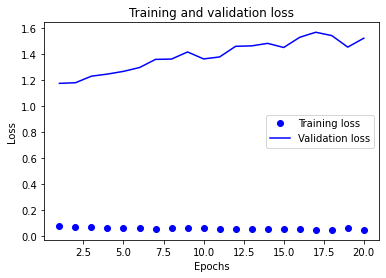

In [42]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

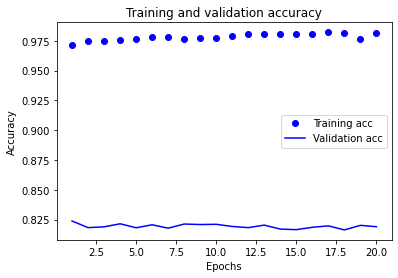

In [43]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

In [44]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [47]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.30576918, -0.2204083 ,  0.14736128,  0.09095478, -0.00072311,
       -0.06082489,  0.07973967,  0.14275408,  0.04504026,  0.04133281,
       -0.02762511,  0.02946606,  0.23633233, -0.22104345,  0.1152766 ,
       -0.10936489], dtype=float32)

In [48]:
word_vectors.similar_by_word("사랑")

[('아이유', 0.9063479900360107),
 ('자매', 0.8872089982032776),
 ('바래요', 0.8825881481170654),
 ('요리', 0.8815464377403259),
 ('^', 0.8809682130813599),
 ('쯧쯧', 0.8808639645576477),
 ('밖에', 0.873883068561554),
 ('프랑스', 0.8676546216011047),
 ('헤어지', 0.8618353009223938),
 ('있', 0.8604718446731567)]

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [ ]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=None)
vector = word2vec['사랑']
vector     # 무려 300dim의 워드 벡터입니다.

### 모델 2

In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 13s 6ms/step - loss: 0.5151 - accuracy: 0.7434 - val_loss: 0.3613 - val_accuracy: 0.8411
Epoch 2/15
208/208 [==============================] - 1s 5ms/step - loss: 0.3310 - accuracy: 0.8591 - val_loss: 0.3433 - val_accuracy: 0.8504
Epoch 3/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2949 - accuracy: 0.8769 - val_loss: 0.3409 - val_accuracy: 0.8514
Epoch 4/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2650 - accuracy: 0.8930 - val_loss: 0.3449 - val_accuracy: 0.8535
Epoch 5/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2351 - accuracy: 0.9080 - val_loss: 0.3570 - val_accuracy: 0.8516
Epoch 6/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2030 - accuracy: 0.9236 - val_loss: 0.3795 - val_accuracy: 0.8498
Epoch 7/15
208/208 [==============================] - 1s 5ms/step - loss: 0.1721 - accuracy: 0.9384 - val_loss: 0.4115 - val_accuracy: 0.8437
Epoch

In [51]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

4569/4569 - 7s - loss: 0.2259 - accuracy: 0.9457
[0.22586339712142944, 0.9456772804260254]


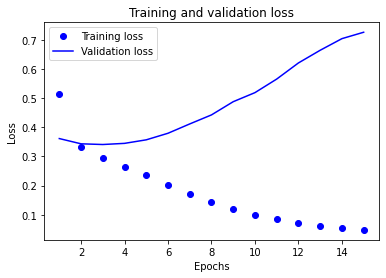

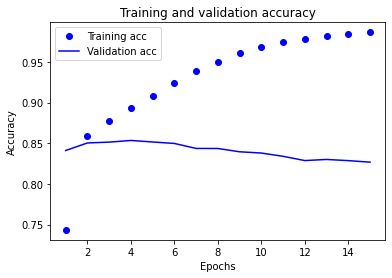

In [75]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [53]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

word_vectors.similar_by_word("사랑")

(10000, 16)


[('드디어', 0.8381863236427307),
 ('짱', 0.8311742544174194),
 ('남겼', 0.8137132525444031),
 ('에디', 0.8129683136940002),
 ('씁시다', 0.7946054935455322),
 ('스텝', 0.7928963303565979),
 ('공상', 0.7874861359596252),
 ('정재영', 0.7823048233985901),
 ('세', 0.7762120366096497),
 ('생각', 0.7730986475944519)]

### 모델 3

In [79]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 1s 4ms/step - loss: 0.6059 - accuracy: 0.7460 - val_loss: 0.4608 - val_accuracy: 0.8115
Epoch 2/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3958 - accuracy: 0.8329 - val_loss: 0.3711 - val_accuracy: 0.8356
Epoch 3/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3362 - accuracy: 0.8577 - val_loss: 0.3566 - val_accuracy: 0.8438
Epoch 4/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3057 - accuracy: 0.8727 - val_loss: 0.3534 - val_accuracy: 0.8448
Epoch 5/15
208/208 [==============================] - 1s 4ms/step - loss: 0.2833 - accuracy: 0.8838 - val_loss: 0.3555 - val_accuracy: 0.8465
Epoch 6/15
208/208 [==============================] - 1s 4ms/step - loss: 0.2648 - accuracy: 0.8927 - val_loss: 0.3619 - val_accuracy: 0.8458
Epoch 7/15
208/208 [==============================] - 1s 4ms/step - loss: 0.2490 - accuracy: 0.9012 - val_loss: 0.3693 - val_accuracy: 0.8451
Epoch 

In [80]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4736 - accuracy: 0.8292
[0.4735638499259949, 0.8291596174240112]


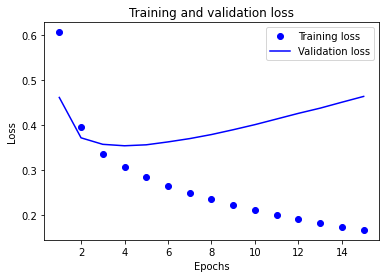

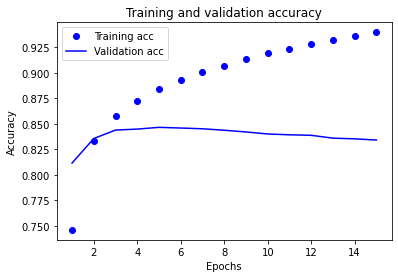

In [81]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [83]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

word_vectors.similar_by_word("사랑")

(10000, 16)


[('살아간다', 0.9147763848304749),
 ('충만', 0.8970004320144653),
 ('여러모로', 0.886588990688324),
 ('the', 0.885917603969574),
 ('흥미', 0.8774753212928772),
 ('밖에', 0.8751587867736816),
 ('냄새', 0.8663339018821716),
 ('광구', 0.8593485951423645),
 ('가위', 0.8531427383422852),
 ('결과물', 0.8527617454528809)]

# 회고

일단은 배운대로 데이터를 가져오는 것부터 유사단어 찾는 것 까지했다. 한국어 Word2Vec는 더 시도해봐야겠다.